# Executing Cluster Analysis

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [5]:
covid_cases = pd.read_csv('/Users/georgetarasenko/Desktop/virus/mash/covidadress_upd (2).csv')
covid_cases_short = covid_cases[0:97] #slicing cases realted only to March, 24 only

In [6]:
#converting it to GeoDataframe
covid_cases_short['lon'], covid_cases_short['lat'] = covid_cases_short['lonlat'].str.split(' ', 1).str
covid_cases_short = gpd.GeoDataFrame(covid_cases_short, geometry=gpd.points_from_xy(covid_cases_short['lon'].astype(float), covid_cases_short['lat'].astype(float)))


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
#cleaning the dataset from observations not belonging to Moscow and its suburbs 
#then dropping obseravtions that are farther than 3sd from the mean
scaled_features = covid_cases_short
#no need to actually scale them because of the same measurement system among all the features for clustering
scaled_features['lon'] = scaled_features ['lon'].astype(float)
scaled_features ['lat'] = scaled_features ['lat'].astype(float)
scaled_features  = scaled_features[scaled_features.lat < 56.0]
scaled_features  = scaled_features[scaled_features.lat > 55.0]
scaled_features  = scaled_features[scaled_features.lon < 38.2]
scaled_features  = scaled_features[scaled_features.lon > 37.0]
scaled_features  = scaled_features[scaled_features.lat < (scaled_features['lat'].mean() + 3*scaled_features['lat'].std())]
scaled_features  = scaled_features[scaled_features.lat > (scaled_features['lat'].mean() - 3*scaled_features['lat'].std())]
scaled_features  = scaled_features[scaled_features.lon < (scaled_features['lon'].mean() + 3*scaled_features['lon'].std())]
scaled_features  = scaled_features[scaled_features.lon > (scaled_features['lon'].mean() - 3*scaled_features['lon'].std())]
scaled_features = (scaled_features[['lon', 'lat']].dropna())

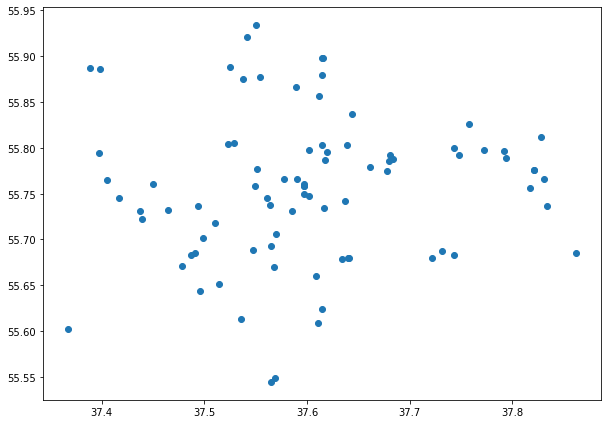

In [8]:
#visaulizing observations
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.subplots_adjust(bottom=0.1)
plt.scatter(scaled_features['lon'],scaled_features['lat'], label='True Position')
plt.show()

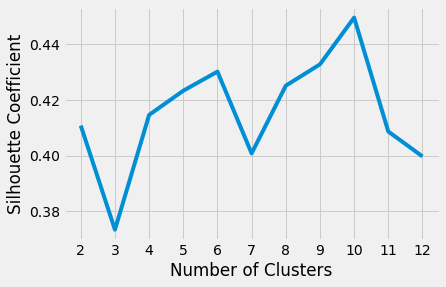

In [12]:
#finding optimal number of clusters 
kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42,
   }
silhouette_coefficients = []
for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)
    plt.style.use("fivethirtyeight")
plt.plot(range(2, 13), silhouette_coefficients)
plt.xticks(range(2, 13))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [14]:
kmeans = KMeans(init="random",
                n_clusters=10,
                n_init=100,
                max_iter=10000,
                random_state=42)
kmeans.fit(scaled_features)
y_kmeans = kmeans.predict(scaled_features)
print(kmeans.fit(scaled_features),
kmeans.inertia_,
kmeans.cluster_centers_,)

KMeans(init='random', max_iter=10000, n_clusters=10, n_init=100,
       random_state=42) 0.14336512364329387 [[37.5753973  55.8892004 ]
 [37.73203567 55.68328333]
 [37.39466467 55.85563767]
 [37.80175531 55.77734692]
 [37.556493   55.56915433]
 [37.64648908 55.79024533]
 [37.51355136 55.68570036]
 [37.62483217 55.655266  ]
 [37.42585643 55.72270186]
 [37.57550644 55.75660012]]


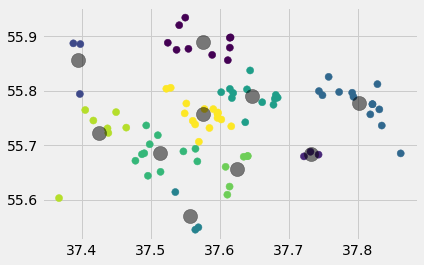

In [15]:
plt.scatter(scaled_features['lon'], scaled_features['lat'], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [18]:
cluster_centroids_24mar =  pd.DataFrame(kmeans.cluster_centers_, columns = ['lon', 'lat'])
cluster_centroids_24mar= gpd.GeoDataFrame(cluster_centroids_24mar, geometry=gpd.points_from_xy(cluster_centroids_24mar['lon'].astype(float), cluster_centroids_24mar['lat'].astype(float)))
#downloading the file with precincts borders
uiks = gpd.read_file('/Users/georgetarasenko/Desktop/precincts 2.csv')
#calculating centroid of each precinct
uiks['centroid'] = uiks['geometry'].centroid
#calculating shortest Eucledian distance to COVID-19 cluster 
uiks['closest_cluster_24mar_dist'] = uiks['centroid'].apply(lambda x: cluster_centroids_24mar['geometry'].distance(x).min())


In [30]:
uiks['uik_number'] = uiks['uik_num']
uiks_instr = uiks[['uik_number', 'closest_cluster_24mar_dist']]

In [31]:
uiks_instr 

,uik_number,closest_cluster_24mar_dist
0,3609,0.030236
1,1760,0.067421
2,2766,0.007262
3,3035,0.063160
4,2429,0.032507
...,...,...
3483,2541,0.240904
3484,3315,0.277421
3485,3312,0.305041
3486,3313,0.291989


In [32]:
uiks_instr.to_csv('uiks_instrument.csv', index=False)